In [1]:
!pip install git+https://github.com/facebookresearch/pytorchvideo.git > /dev/null 2>&1

In [2]:
import json
import os
import warnings
import gc
import random
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler

import torchvision.transforms as transforms
from torchvision.transforms import CenterCrop

import pytorchvideo.data
import pytorchvideo.transforms as pv_transforms
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import UniformTemporalSubsample, ShortSideScale, Normalize, Permute

from transformers import VivitModel, VivitConfig

warnings.filterwarnings("ignore")

2025-06-17 16:35:27.212414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750178127.655531      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750178127.764241      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)  # Фиксируем seed для встроенного генератора Python
    np.random.seed(seed)  # Фиксируем seed для NumPy
    torch.manual_seed(seed)  # Фиксируем seed для PyTorch (CPU)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # Фиксируем seed для PyTorch (CUDA)
        torch.cuda.manual_seed_all(seed)  # Фиксируем seed для всех доступных GPU
        torch.backends.cudnn.deterministic = True  # Гарантируем детерминированность CUDNN
        torch.backends.cudnn.benchmark = False  # Отключаем эвристику для оптимизации скорости

# Вызов функции для установки seed
set_seed(0x3df3fa)

In [4]:
def time_to_seconds(time_str):
    """
    Преобразует строку времени формата 'HH:MM:SS' или 'MM:SS' в секунды.
    """
    parts = list(map(int, time_str.split(':')))
    if len(parts) == 3:
        h, m, s = parts
    elif len(parts) == 2:
        h = 0
        m, s = parts
    else:
        raise ValueError(f"Неверный формат времени: {time_str}. Ожидается HH:MM:SS или MM:SS.")
    return h * 3600 + m * 60 + s

def prepare_data_labels(labels_file_path, video_dir_path):
    """
    Загружает метки из JSON-файла и сопоставляет их с путями к видеофайлам.

    Args:
        labels_file_path (str): Путь к файлу labels.json.
        video_dir_path (str): Путь к директории с видеофайлами.

    Returns:
        dict: Словарь, где ключ - это полный путь к видеофайлу,
              а значение - словарь с 'start' и 'end' временем в секундах.
    """
    video_labels = {}
    
    # Загружаем метки из JSON-файла
    with open(labels_file_path, 'r') as f:
        labels_data = json.load(f)

    # Итерируемся по меткам и сопоставляем их с видеофайлами
    for key, value in labels_data.items():
        video_filename = f"processed_{key}.mp4"
        if key == '-220020068_456241673' or key == '-220020068_456241682':
            continue
        full_video_path = os.path.join(video_dir_path, video_filename)

        # Проверяем, существует ли файл
        if os.path.exists(full_video_path):
            start_seconds = time_to_seconds(min(value['start'], value['end']))
            end_seconds = time_to_seconds(max(value['start'], value['end']))
            video_labels[full_video_path] = {
                'start': start_seconds,
                'end': end_seconds
            }
        else:
            continue
            
    return video_labels

# Определяем пути (на Kaggle они будут такими)
LABELS_FILE = '/kaggle/input/vk-10-min-videos-dataset-with-labels/trimmed_videos_with_labels/labels.json'
VIDEO_DIR = '/kaggle/input/vk-10-min-videos-dataset-with-labels/trimmed_videos_with_labels'

# Запускаем подготовку данных
all_video_data = prepare_data_labels(LABELS_FILE, VIDEO_DIR)

print(f"Всего найдено видео с метками: {len(all_video_data)}")

# Выведем первые несколько элементов для проверки
for i, (video_path, labels) in enumerate(all_video_data.items()):
    if i >= 3: # Выводим только первые 3 примера
        break
    print(f"Видео: {os.path.basename(video_path)}")
    print(f"  Начало заставки (сек): {labels['start']}")
    print(f"  Конец заставки (сек): {labels['end']}")
    print("-" * 20)

Всего найдено видео с метками: 71
Видео: processed_-220020068_456255414.mp4
  Начало заставки (сек): 102
  Конец заставки (сек): 107
--------------------
Видео: processed_-220020068_456249693.mp4
  Начало заставки (сек): 6
  Конец заставки (сек): 10
--------------------
Видео: processed_-220020068_456255339.mp4
  Начало заставки (сек): 10
  Конец заставки (сек): 20
--------------------


In [5]:
# --- Трансформации для видео ---
NUM_FRAMES = 32  # Количество кадров, которое будет подаваться в трансформер
SIDE_SIZE = 224  # Размер кадра (H, W)
MEAN = (0.45, 0.45, 0.45) 
STD = (0.225, 0.225, 0.225) 
FPS = 30 # Предполагаемая частота кадров видео

video_transform = transforms.Compose([
    UniformTemporalSubsample(NUM_FRAMES), # Выборка NUM_FRAMES кадров из клипа
    ShortSideScale(size=SIDE_SIZE),        # Масштабирование короткой стороны
    CenterCrop((SIDE_SIZE, SIDE_SIZE)),    # Обрезка по центру
    Normalize(mean=MEAN, std=STD),         # Нормализация
    Permute((1, 0, 2, 3)),                 # Изменение порядка осей с (T, C, H, W) на (C, T, H, W)
])


def collate_fn_with_filter(batch):
    """
    Функция для collate_fn в DataLoader, которая отфильтровывает None.
    """
    batch = list(filter(lambda x: x[0] is not None, batch)) 
    if not batch: 
        return None, None
    return torch.utils.data.dataloader.default_collate(batch)

class CustomVideoDataset(Dataset):
    """
    Пользовательский класс Dataset для загрузки видео и их меток,
    использующий pytorchvideo.data.EncodedVideo для эффективной загрузки клипов.
    """
    def __init__(self, video_data, clip_sampler_duration_sec, transform=None):
        self.video_paths = list(video_data.keys())
        self.labels = video_data
        self.transform = transform
        self.clip_sampler_duration_sec = clip_sampler_duration_sec

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        # Исключаем 16-й элемент (индекс 15)
        if idx in[15, 35]:
            print(f"Исключаем элемент с индексом {idx} (16-й элемент) из датасета.")
            return None, None

        video_path = self.video_paths[idx]
        
        if not os.path.exists(video_path):
            print(f"Ошибка: Видеофайл не найден по пути: {video_path}")
            return None, None

        try:
            try:
                video_obj = EncodedVideo.from_path(video_path)
            except Exception as e:
                print(f"Ошибка при инициализации EncodedVideo для {video_path}: {e}")
                return None, None
            
            video_duration = video_obj.duration
            
            clip_start_sec = 0.0
            sample_clip_duration_sec = min(self.clip_sampler_duration_sec, video_duration) 
            clip_end_sec = clip_start_sec + sample_clip_duration_sec

            if clip_end_sec <= clip_start_sec: 
                print(f"Видео {video_path} слишком короткое для семплирования клипа (продолжительность: {video_duration:.2f} сек).")
                return None, None

            try:
                clip_data = video_obj.get_clip(clip_start_sec, clip_end_sec)
                if clip_data is None or 'video' not in clip_data or clip_data['video'] is None:
                    print(f"Ошибка: `video_obj.get_clip` для {video_path} не вернул видеоданные. Получено: {clip_data}")
                    return None, None
                
                video_tensor = clip_data['video'] 

            except Exception as e:
                print(f"Ошибка при вызове get_clip или извлечении видео-тензора для {video_path}: {e}")
                return None, None
            if not isinstance(video_tensor, torch.Tensor):
                print(f"Ошибка: `video_obj.get_clip()['video']` для {video_path} не вернул тензор. Тип: {type(video_tensor)}. Содержимое: {video_tensor}")
                return None, None

            if self.transform:
                video_tensor = self.transform(video_tensor)

            start_sec = self.labels[video_path]['start']
            end_sec = self.labels[video_path]['end']
            labels_tensor = torch.tensor([start_sec, end_sec], dtype=torch.float16)

            return video_tensor, labels_tensor
        except Exception as e:
            print(f"Общая ошибка при загрузке или обработке видео {video_path}: {e}")
            return None, None

dataset = CustomVideoDataset(all_video_data, 
                             clip_sampler_duration_sec=30.0, 
                             transform=video_transform)

total_videos = len(dataset)
train_size = min(30, total_videos) 
test_size = total_videos - train_size


train_dataset, test_dataset = random_split(dataset, [train_size, test_size], 
                                           generator=torch.Generator().manual_seed(42)) 

print(f"Размер обучающей выборки: {len(train_dataset)} видео")
print(f"Размер тестовой выборки: {len(test_dataset)} видео")

BATCH_SIZE = 1
NUM_WORKERS = 0

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=NUM_WORKERS, collate_fn=collate_fn_with_filter)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=NUM_WORKERS, collate_fn=collate_fn_with_filter)

Размер обучающей выборки: 30 видео
Размер тестовой выборки: 41 видео


In [6]:
print("\nПроверка загрузки данных из DataLoader'ов:")
for i, (video_batch, labels_batch) in enumerate(train_loader):
    if video_batch is None:
        print(f"Пропущен пустой батч (ошибка загрузки видео) на итерации {i}")
        continue
    print(f"  Обучающий батч {i+1}:")
    print(f"    Форма видео-тензора: {video_batch.shape} (Batch, Channels, Frames, Height, Width)")
    print(f"    Форма тензора меток: {labels_batch.shape} (Batch, [start_sec, end_sec])")
    print(f"    Пример меток: {labels_batch[0].tolist()}")
    if i >= 0: 
        break


Проверка загрузки данных из DataLoader'ов:
  Обучающий батч 1:
    Форма видео-тензора: torch.Size([1, 32, 3, 224, 224]) (Batch, Channels, Frames, Height, Width)
    Форма тензора меток: torch.Size([1, 2]) (Batch, [start_sec, end_sec])
    Пример меток: [65.0, 75.0]


In [7]:
print("\nПроверка тестового DataLoader'а:")
for i, (video_batch, labels_batch) in enumerate(test_loader):
    if video_batch is None:
        print(f"Пропущен пустой батч (ошибка загрузки видео) на итерации {i}")
        continue
    print(f"  Тестовый батч {i+1}:")
    print(f"    Форма видео-тензора: {video_batch.shape}")
    print(f"    Форма тензора меток: {labels_batch.shape}")
    print(f"    Пример меток: {labels_batch[0].tolist()}")
    break


Проверка тестового DataLoader'а:
  Тестовый батч 1:
    Форма видео-тензора: torch.Size([1, 32, 3, 224, 224])
    Форма тензора меток: torch.Size([1, 2])
    Пример меток: [6.0, 10.0]


In [8]:
class VivitForVideoRegression(nn.Module):
    def __init__(self, vivit_model_name="google/vivit-b-16x2-kinetics400", num_regression_outputs=2):
        super().__init__()
        # 1. Загружаем предварительно обученную модель ViViT
        # Мы загружаем модель без головного классификационного слоя, чтобы добавить свой.
        # VivitModel предоставляет доступ к основной части модели (body)
        self.vivit = VivitModel.from_pretrained(vivit_model_name)

        # 2. Замораживаем все параметры ViViT
        for param in self.vivit.parameters():
            param.requires_grad = False

        # 3. Добавляем новый линейный слой для регрессии
        self.regression_head = nn.Linear(self.vivit.config.hidden_size, num_regression_outputs)

    def forward(self, pixel_values):
        outputs = self.vivit(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        predictions = self.regression_head(pooled_output)
        return predictions


# Инициализация модели:
model = VivitForVideoRegression(num_regression_outputs=2)
print(model)

# Проверка, что только новый слой обучаем:
print("\nПроверка обучаемых параметров:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Обучаемый параметр: {name}, Форма: {param.shape}")
    else:
        print(f"Замороженный параметр: {name}, Форма: {param.shape}")

config.json:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/356M [00:00<?, ?B/s]

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VivitForVideoRegression(
  (vivit): VivitModel(
    (embeddings): VivitEmbeddings(
      (patch_embeddings): VivitTubeletEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): VivitEncoder(
      (layer): ModuleList(
        (0-11): 12 x VivitLayer(
          (attention): VivitAttention(
            (attention): VivitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): VivitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VivitIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=T

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 10

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',         
    factor=0.3,         
    patience=3,         
    verbose=True,       
    min_lr=1e-6         
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
scaler = GradScaler()
print(f"Используемое устройство: {device}")

# Списки для хранения потерь для построения графика
train_losses = []
test_losses = []
all_test_predictions = []
all_test_labels = []

model.safetensors:   0%|          | 0.00/356M [00:00<?, ?B/s]

Используемое устройство: cuda


In [10]:
# Создадим директорию для сохранения чекпоинтов, если ее нет
checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [11]:
for epoch in range(num_epochs):
    # --- Фаза обучения ---
    model.train() # Переводим модель в режим обучения
    total_train_loss = 0
    print(f"\n--- Эпоха {epoch+1}/{num_epochs} --- (Текущий LR: {optimizer.param_groups[0]['lr']:.6f})") # Добавляем вывод текущего LR

    with tqdm(train_loader, unit="batch", desc=f"Обучение (Эпоха {epoch+1})") as t_loader:
        for i, (video_batch, labels_batch) in enumerate(t_loader):
            
            video_batch = video_batch.to(device)
            labels_batch = labels_batch.to(device)

            optimizer.zero_grad()
            # Wrap operations with autocast
            with autocast():
                outputs = model(video_batch)
                loss = criterion(outputs, labels_batch)

            # Scale loss and perform backward pass
            scaler.scale(loss).backward()
            # Optimizer step and update scaler
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.item()
            t_loader.set_postfix(loss=loss.item())

            if (i + 1) % 10 == 0: 
                    gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Эпоха {epoch+1}/{num_epochs}, Средние потери на обучении: {avg_train_loss:.4f}")


    # --- Сохранение чекпоинта модели ---
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None, # Сохраняем и состояние планировщика, если он есть
    }, checkpoint_path)
    print(f"Чекпоинт сохранен: {checkpoint_path}")


--- Эпоха 1/10 --- (Текущий LR: 0.000500)



Обучение (Эпоха 1): 100%|██████████| 30/30 [03:50<00:00,  7.67s/batch, loss=6.23e+4]


Эпоха 1/10, Средние потери на обучении: 36843.2734
Чекпоинт сохранен: model_checkpoints/model_epoch_1.pth

--- Эпоха 2/10 --- (Текущий LR: 0.000500)


Обучение (Эпоха 2): 100%|██████████| 30/30 [03:08<00:00,  6.28s/batch, loss=1.06e+4]


Эпоха 2/10, Средние потери на обучении: 36295.6038
Чекпоинт сохранен: model_checkpoints/model_epoch_2.pth

--- Эпоха 3/10 --- (Текущий LR: 0.000500)


Обучение (Эпоха 3): 100%|██████████| 30/30 [02:54<00:00,  5.80s/batch, loss=2.73e+4]


Эпоха 3/10, Средние потери на обучении: 35690.6338
Чекпоинт сохранен: model_checkpoints/model_epoch_3.pth

--- Эпоха 4/10 --- (Текущий LR: 0.000500)


Обучение (Эпоха 4): 100%|██████████| 30/30 [02:50<00:00,  5.68s/batch, loss=3.45e+4]


Эпоха 4/10, Средние потери на обучении: 35192.1597
Чекпоинт сохранен: model_checkpoints/model_epoch_4.pth

--- Эпоха 5/10 --- (Текущий LR: 0.000500)


Обучение (Эпоха 5): 100%|██████████| 30/30 [02:50<00:00,  5.68s/batch, loss=3.37e+3]


Эпоха 5/10, Средние потери на обучении: 34657.7907
Чекпоинт сохранен: model_checkpoints/model_epoch_5.pth

--- Эпоха 6/10 --- (Текущий LR: 0.000500)


Обучение (Эпоха 6): 100%|██████████| 30/30 [02:51<00:00,  5.72s/batch, loss=60.7]


Эпоха 6/10, Средние потери на обучении: 34164.0599
Чекпоинт сохранен: model_checkpoints/model_epoch_6.pth

--- Эпоха 7/10 --- (Текущий LR: 0.000500)


Обучение (Эпоха 7): 100%|██████████| 30/30 [02:51<00:00,  5.72s/batch, loss=9.63e+3]


Эпоха 7/10, Средние потери на обучении: 33731.8563
Чекпоинт сохранен: model_checkpoints/model_epoch_7.pth

--- Эпоха 8/10 --- (Текущий LR: 0.000500)


Обучение (Эпоха 8): 100%|██████████| 30/30 [02:52<00:00,  5.74s/batch, loss=80.3]


Эпоха 8/10, Средние потери на обучении: 33246.7728
Чекпоинт сохранен: model_checkpoints/model_epoch_8.pth

--- Эпоха 9/10 --- (Текущий LR: 0.000500)


Обучение (Эпоха 9): 100%|██████████| 30/30 [02:51<00:00,  5.72s/batch, loss=2.54e+3]


Эпоха 9/10, Средние потери на обучении: 32839.9207
Чекпоинт сохранен: model_checkpoints/model_epoch_9.pth

--- Эпоха 10/10 --- (Текущий LR: 0.000500)


Обучение (Эпоха 10): 100%|██████████| 30/30 [02:50<00:00,  5.67s/batch, loss=4.82e+3]


Эпоха 10/10, Средние потери на обучении: 32393.2686
Чекпоинт сохранен: model_checkpoints/model_epoch_10.pth



--- Строим график потерь обучения и тестирования ---


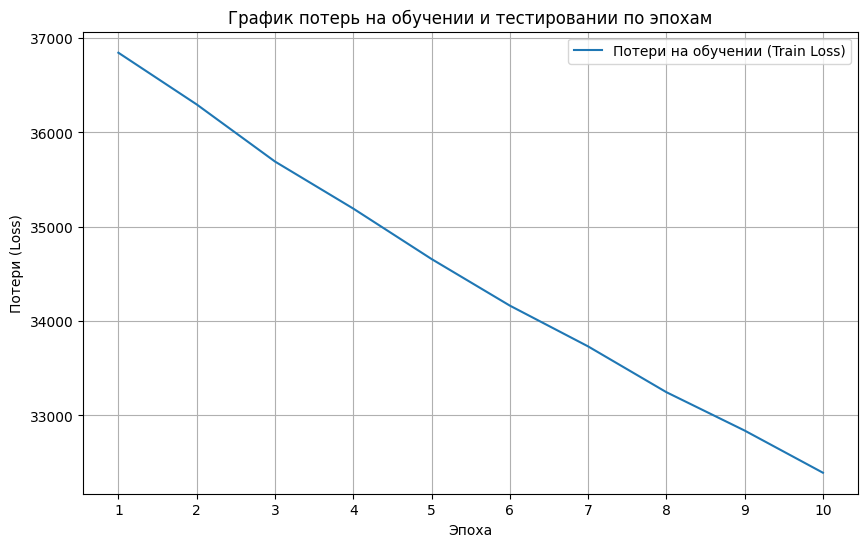

In [12]:
print("\n--- Строим график потерь обучения и тестирования ---")
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Потери на обучении (Train Loss)')
plt.xlabel('Эпоха')
plt.ylabel('Потери (Loss)')
plt.title('График потерь на обучении и тестировании по эпохам')
plt.legend()
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))
plt.show()